## Resources used

* VAE-CP paper: https://roseyu.com/time-series-workshop/submissions/2021/TSW-ICML2021_paper_4.pdf
* TS-CP^2 paper: https://arxiv.org/pdf/2011.14097.pdf
* Timestep-wise negative variational lower bound paper: https://arxiv.org/pdf/2005.11437.pdf
* TimeVAE paper: https://arxiv.org/abs/2111.08095

* https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/
* https://tech.gorilla.co/how-can-we-quantify-similarity-between-time-series-ed1d0b633ca0
* https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/09/14/01-Maximizing-the-ELBO.html
* https://www.tensorflow.org/tutorials/generative/cvae
* https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
* https://danijar.com/building-variational-auto-encoders-in-tensorflow/
* https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/
* https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
* https://github.com/abudesai/timeVAE

## Introduction
This Jupyter Notebook is an attempt to recreate the VAE-CP model described in *Changepoint Detection using Self Supervised Variational AutoEncoders* (https://roseyu.com/time-series-workshop/submissions/2021/TSW-ICML2021_paper_4.pdf). The background will introduce Variational AutoEncoders (VAEs) as well as some specific design choices made by the author of the VAE-CP paper. There will be comments throughout the notebook about parts that are unclear and my own assumptions made.

## Background
As the name VAE-CP aludes to, the model is built around a VAE. The author of the VAE-CP paper explains the reasoning behind using a VAE *"we wish to learn an encoder, from an window X_wt, to its corresponding latent value zt, in a continuous space, such that the encoding is informative of the segment of the time series"*. The latent values zt:s are then used in combination with traditional CPD methods for the actual change point detection.    

**Variational AutoEncoder**    
<img src="image/vae-diagram.jpg" alt= “VAE” width="40%" height="40%">

**Input**  
The input to our VAE is one-dimensional time series data. This can be extended to multi-dimensional. One parameter when creating the VAE is the length of a window (a slice of the time series), which will determine the size of the input and output layer of the VAE. The windowing procedure is described in the VAE-CP paper as following *"We will work with windows of size w. At the current time t, we consider the window Xw t = {xt−w, xt−w+1, .....xt−1}."*. However, the plots in the paper suggest that the windowing procedure is the following *At the current time t, we consider the window Xw t = {xt, xt+1, .....xt+w}*. The plot in question can be seen below and the evidence for my claim is the fact that the plot for latent values stops at timestamp 480 when the window size is 20:  
<img src="image/vae-cp-fig2.png" alt=“VAE”  width="40%" height="40%">

**Encoder**  
The author of VAE-CP describes the encoder as following, *"The architecture of the encoder φencoder consists of a fully connected layer, followed by RELU activation, to generate a hidden state. We then use two separate fully connected layers to generate µt and log(σt)"*. The latent vector/variables will then be sampled from the µt and σt using the reparameterization trick (which allows us to use gradient descent in training) as seen below:  
<img src="image/reparameterization_trick.png" alt=“VAE”  width="10%" height="10%">

**Decoder**  
The author of VAE-CP describes the decoder as following, *"The decoder ψdecoder similarly consists of an MLP with a single hidden layer and RELU activation."*. This sounds like a very simple MLP network and not like other VAE decoders I've seen online, which makes use of the sampling procedure in the decoder as well. One example of this is: https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/  

**Loss Function**  
The loss function for the VAE is described as Elbo loss + Triplet loss. The loss function from the pseudo code of the approach can be seen below:  
<img src="image/vae-cp_lossfunc.png" alt=“VAE”  width="30%" height="30%">  
Where the Elbo loss is defined as the following:  
<img src="image/elbo_loss.png" alt=“VAE”  width="30%" height="30%">  
and the triplet loss is defined as the following:  
<img src="image/triplet_loss.png" alt=“VAE”  width="30%" height="30%">  

**Sampling**  
The author also describes a sampling procedure which first samples as window (X_wt), then a nearby window called neighbour (X_wt_prime), and finally a negative sample (X_wt_neg) which is the first sample with a random trend added to it. The description of the negative sample can be seen in the picture of the triplet loss and the description of sampling a neighbour is phrased in the paper as:  
*"To encourage a representation of zt that contains information about the segment it belongs to, we train latent representation to be similar to a nearby ”neighbor” window. For each window Xw t , we randomly sample another window Xw t 0 , such that the windows are nearby, i.e. |t − t 0 | ≤ L, where L is an user defined limit, which determines the smoothing. This helps us obtain latent representations that are independent of local effects within the segment"*  

**Pseudo code**  
<img src="image/vae-cp_pseudocode.png" alt=“VAE”  width="40%" height="40%"> 

**Architecture choices**  
The author describes the architecture of the VAE and some parameters as following:  
*"We use a window size w = 20. We also set L = 20, which is the region in which we search for a neighboring window. This parameter is critical, and choosing it to be higher than the seasonality helps in erasing the effects of seasonality. Our goal is to learn a latent representation, that is representative of the segment, and controlling L helps us achieve that. Both for our encoder and decoder, we use a fully connected layer, with 64 units in the hidden layer."*  

With these basics covered, we're now ready for the implementation! :)

## Imports
This code is written and run using Python 3.8 and the following versions of the imported libraries:
* numpy 1.22.4
* tensorflow 2.10.1
* matplotlib 3.5.2
* pandas 1.5.1

In [160]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import Mean
from tensorflow.keras.backend import random_normal
from tensorflow.keras.optimizers import Adam
import time
import random
import matplotlib.pyplot as plt
import pandas as pd

## Sampling of latent variables
This class solely exists to make use of in the Encoder for the reparameterization trick, which in turn allows us to run backpropagation through the network.

In [161]:
class Sampling(Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  def call(self, inputs):
      z_mean, z_log_var = inputs
      batch = tf.shape(z_mean)[0]
      dim = tf.shape(z_mean)[1]
      epsilon = random_normal(shape=(batch, dim))
      return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

<img src="image/encoder.png" alt=“VAE”  width="20%" height="20%">  

The encoder takes input, hidden and latent variable dimensions as input. The author of the VAE-CP paper used parameters input_dim=20, hidden_dim=64 and latent_dim=2. After the hidden layer, with relu activation function, two separate dense layers for generating the z_mean and z_log_var. Original description: *"We then use two separate fully connected layers to generate µt and log(σt)"*. The variables z_mean and z_log_var are then fed to the sampler which samples the variables to create the output (z).

In [162]:
class Encoder(object):
  def __init__(self, input_dim=None, hidden_dim=None, latent_dim=None):
    self.encoder_inputs = tf.keras.layers.Input(shape=input_dim, name="encoder_input")
    encoder_dense = tf.keras.layers.Dense(units=hidden_dim, activation='relu', name="encoder_hidden")(self.encoder_inputs)
    z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(encoder_dense)
    z_log_var = tf.keras.layers.Dense(units=latent_dim, name="z_log_var")(encoder_dense)
    self.encoder_output = Sampling()([z_mean, z_log_var])
    self.model = tf.keras.models.Model(self.encoder_inputs, [z_mean, z_log_var, self.encoder_output], name="encoder")

  def get_encoder(self):
    return self.model

## Decoder

The decoder very simply consists of a MLP with 1 hidden layer. The decoder goes from latent_dim, to hidden_dim, to input_dim (which now becomes the output).

In [163]:
class Decoder(object):
  def __init__(self, input_dim=None, hidden_dim=None, latent_dim=None):
    decoder_input = tf.keras.layers.Input(shape=(latent_dim), name="decoder_input")
    decoder_dense = tf.keras.layers.Dense(units=hidden_dim, activation='relu', name="decoder_hidden")(decoder_input)
    decoder_output = tf.keras.layers.Dense(units=input_dim, activation='relu', name="decoder_output")(decoder_dense)
    self.model = tf.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

  def get_decoder(self):
    return self.model

## VAE-CP

In [164]:
class VAE_CP(Model):
  def __init__(self, input_dim=None, hidden_dim=None, latent_dim=None):
    super(VAE_CP, self).__init__()
    
    # Store some variables
    self.input_dim = input_dim
    self.latent_dim = latent_dim

    # Create loss trackers
    self.total_loss_tracker = Mean(name="total_loss")
    self.reconstruction_loss_tracker = Mean( name="reconstruction_loss" )
    self.kl_loss_tracker = Mean(name="kl_loss")
    self.triplet_loss_tracker = Mean(name="triplet_loss")
    self.elbo_loss_tracker = Mean(name="elbo_loss")

    # Create the encoder and decoder
    self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).get_encoder()
    self.decoder = Decoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).get_decoder()

  def call(self, X):
    '''
    The call method overwrites tensorflow.keras.models method for generating output of the class
    '''
    z_mean, _, _ = self.encoder(X)
    x_decoded = self.decoder(z_mean)
    if len(x_decoded.shape) == 1: x_decoded = x_decoded.reshape((1, -1))
    return x_decoded
  
  def get_num_trainable_variables(self):
    '''
    The get_num_trainable_variables method overwrites tensorflow.keras.models method
    '''
    trainableParams = int(np.sum([np.prod(v.get_shape()) for v in self.trainable_weights]))
    nonTrainableParams = int(np.sum([np.prod(v.get_shape()) for v in self.non_trainable_weights]))
    totalParams = trainableParams + nonTrainableParams
    return trainableParams, nonTrainableParams, totalParams
  
  def get_prior_samples(self, num_samples):
    '''
    This method is not used
    '''
    Z = np.random.randn(num_samples, self.latent_dim)
    samples = self.decoder.predict(Z)
    return samples
    
  def get_prior_samples_given_Z(self, Z):
    '''
    This method is not used
    '''
    samples = self.decoder.predict(Z)
    return samples
  
  def summary(self):
    '''
    The summary method overwrites tensorflow.keras.models method
    '''
    self.encoder.summary()
    self.decoder.summary()

  def _get_reconstruction_loss(self, X, X_recons): 
    '''
    This method follows the implementation of https://github.com/abudesai/timeVAE
    '''
    def get_reconst_loss_by_axis(X, X_c, axis): 
        x_r = tf.reduce_mean(X, axis = axis)
        x_c_r = tf.reduce_mean(X_recons, axis = axis)
        err = tf.math.squared_difference(x_r, x_c_r)
        loss = tf.reduce_sum(err)
        return loss

    # overall    
    err = tf.math.squared_difference(X, X_recons)
    reconst_loss = tf.reduce_sum(err)
  
    reconst_loss += get_reconst_loss_by_axis(X, X_recons, axis=[1])    # by feature axis
    return reconst_loss
  
  def _get_elbo_loss(self, X, z_mean, z_log_var, z_prime):
    '''
    This method follows the implementation of https://github.com/abudesai/timeVAE
    '''
    reconstruction = self.decoder(z_prime)
    reconstruction_loss = self._get_reconstruction_loss(X, reconstruction)

    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_sum(tf.reduce_sum(kl_loss, axis=1))

    elbo_loss = reconstruction_loss + self.gamma * kl_loss
    return elbo_loss, reconstruction_loss, kl_loss
  
  def _get_triplet_loss(self, z, z_prime, z_neg):
    # calculate the anchor (a) to positive (p) and negative (n) distance
    ap_distance = tf.reduce_sum(tf.square(z - z_prime), axis=-1)
    an_distance = tf.reduce_sum(tf.square(z - z_neg), axis=-1)
    loss = ap_distance - an_distance
    loss = tf.maximum(loss + self.margin, 0.0)
    return loss
  
  def train(self, X, epochs, smoothing, gamma, margin):
    '''
    The train method follows the pseudo code description seen in Background.
    However, it seems odd to me that we only sample 1 mini batch each epoch,
    since an epoch usually is defined as one run through the whole data.
    '''
    self.smoothing = smoothing
    self.gamma = gamma
    self.margin = margin

    for epoch in range(1, epochs + 1):
      start_time = time.time()
      mini_batch = self.sample_batch(X)
      loss = self.train_step(mini_batch)

      # Print the loss every 10 epochs to avoid spam
      if epoch % 10 == 0:
        print('Epoch: {}, Loss: {}, time elapse for epoch: {}'
            .format(epoch, loss, time.time() - start_time))
      
  def train_step(self, mini_batch):
    # Unpack the mini batch
    X, X_prime, X_neg = mini_batch
    
    with tf.GradientTape() as tape:
      # Generate the needed variables
      z_mean, z_log_var, z = self.encoder(X)
      _, _, z_prime = self.encoder(X_prime)
      _, _, z_neg = self.encoder(X_neg)

      # Calculate the loss
      elbo_loss, reconstruction_loss, kl_loss = self._get_elbo_loss(X, z_mean, z_log_var, z_prime)
      triplet_loss = self._get_triplet_loss(z, z_prime, z_neg)
      total_loss = elbo_loss + triplet_loss

    # Get the gradient
    grads = tape.gradient(total_loss, self.trainable_weights)

    # Run the optimizer
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Update the loss trackers
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    self.triplet_loss_tracker.update_state(triplet_loss)
    self.elbo_loss_tracker.update_state(elbo_loss)

    return {
      "loss": tf.get_static_value(self.total_loss_tracker.result()),
      "reconstruction_loss": tf.get_static_value(self.reconstruction_loss_tracker.result()),
      "kl_loss": tf.get_static_value(self.kl_loss_tracker.result()),
      "elbo_loss": tf.get_static_value(self.elbo_loss_tracker.result()),
      "triplet_loss": tf.get_static_value(self.triplet_loss_tracker.result()),
    }
  
  def test_step(self, mini_batch):
    '''
    This method is not used
    '''
    X, X_prime, X_neg = mini_batch
    z_mean, z_log_var, z = self.encoder(X)
    _, _, z_prime = self.encoder(X_prime)
    _, _, z_neg = self.encoder(X_neg)

    elbo_loss, reconstruction_loss, kl_loss = self._get_elbo_loss(X, z_mean, z_log_var, z_prime)
    triplet_loss = self._get_triplet_loss(z, z_prime, z_neg)
    total_loss = elbo_loss + triplet_loss

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    self.triplet_loss_tracker.update_state(triplet_loss)
    self.elbo_loss_tracker.update_state(elbo_loss)

    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
        "elbo_loss": self.elbo_loss_tracker.result(),
        "triplet_loss": self.triplet_loss_tracker.result(),
    }

  def sample_batch(self, X):
    '''
    This method tries to replicate the description of the sampling procedure outline in the paper
    '''
    max_index = len(X) - self.input_dim
    
    X_wt_index = random.randint(0, max_index)
    
    prime_lower_bound = max(X_wt_index - self.smoothing, 0)
    prime_upper_bound = min(X_wt_index + self.smoothing, max_index)
    X_wt_prime_index = random.randint(prime_lower_bound, prime_upper_bound)

    X_wt = X[X_wt_index:X_wt_index+self.input_dim].reshape(1, self.input_dim)
    X_wt_prime = X[X_wt_prime_index:X_wt_prime_index+self.input_dim].reshape(1, self.input_dim)
    X_wt_neg = self._change_trend(X_wt).reshape(1, self.input_dim)

    return [X_wt, X_wt_prime, X_wt_neg]

  def _change_trend(self, X):
    '''
    This method is a completely self deviced way of chaning trend to a window.
    X is always scaled 0-1. We draw a random number between 0-1 and then add
    a trend such that the window starts in the same position but ends in the 
    random number value
    '''
    new_end = random.uniform(0, 1)
    change_per_step = (new_end - X[-1])/X.shape[-1]
    trend = np.multiply(np.array(range(X.shape[-1])), change_per_step)
    X = X + trend
    return X
  
  def get_latent_values(self, X):
    '''
    This method samples the latent variables to generate
    latent values
    '''
    latent_variables = []
    for i in range(len(X) - self.input_dim + 1):
      window = X[i:i+self.input_dim].reshape(1, self.input_dim)
      _, _, z = self.encoder(window)
      latent_variables.append(tf.get_static_value(z[0]))
    return np.array(latent_variables)

## Read & scale data

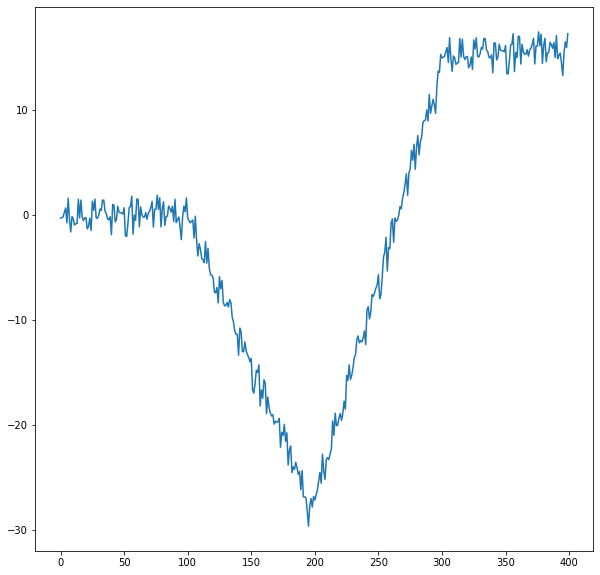

In [165]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('test_data.csv')
test_data = np.float32(df['test'].to_numpy())
plt.plot(test_data)
plt.show()

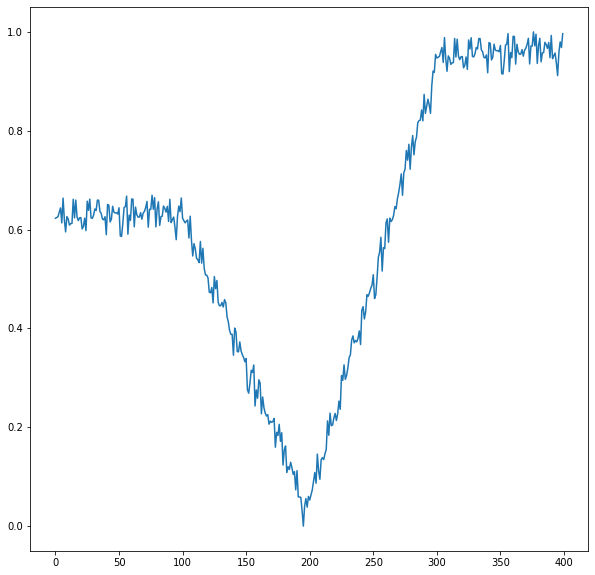

In [166]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(test_data.reshape(-1, 1))

plt.plot(scaled_data)
plt.show()

## Plotting latent values

In [167]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

def plot_latent_variables(latent_values, data):
  plt.rcParams["figure.figsize"] = (10,10)
  figure, axis = plt.subplots(3, 1)

  axis[0].plot(range(100), data[0:100], c='b', label='1')
  axis[0].plot(range(100, 200), data[100:200], c='r', label='2')
  axis[0].plot(range(200, 300), data[200:300], c='y', label='3')
  axis[0].plot(range(300, 400), data[300:], c='orange', label='4')
  axis[0].legend()
  axis[0].grid()
  # plt.show()
  
  x_latent = latent_values[:,0]
  y_latent = latent_values[:,1]
  axis[1].scatter(x_latent[0:100], y_latent[0:100], c='b', label='1')
  axis[1].scatter(x_latent[100:200], y_latent[100:200], c='r', label='2')
  axis[1].scatter(x_latent[200:300], y_latent[200:300], c='y', label='3')
  axis[1].scatter(x_latent[300:400], y_latent[300:400], c='orange', label='4')
  axis[1].legend()
  # plt.show()

  latent_values = list(latent_values)
  while len(latent_values) < 400:
    latent_values.append(np.array([np.nan, np.nan]))
  axis[2].plot(latent_values)
  # axis[2].xlim(right=419)
  axis[2].grid()
  plt.show()

  z = range(400)
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x_latent[0:100], y_latent[0:100], z[0:100], c='b', label='1')
  ax.scatter(x_latent[100:200], y_latent[100:200], z[100:200], c='r', label='2')
  ax.scatter(x_latent[200:300], y_latent[200:300], z[200:300], c='y', label='3')
  ax.scatter(x_latent[300:400], y_latent[300:400], z[300:381], c='orange', label='4')
  plt.show()

## VAE-CP testing

#### Create the model

In [189]:
input_dim = 20
hidden_dim = 64
latent_dim = 2
optimizer = Adam(learning_rate=0.005)

vae_cp = VAE_CP(input_dim=input_dim, hidden_dim=hidden_dim , latent_dim=latent_dim)
vae_cp.compile(optimizer=optimizer)
vae_cp.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 20)]         0           []                               
                                                                                                  
 encoder_hidden (Dense)         (None, 64)           1344        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            130         ['encoder_hidden[0][0]']         
                                                                                                  
 z_log_var (Dense)              (None, 2)            130         ['encoder_hidden[0][0]']         
                                                                                            

#### Plot the latent values pre training

Right now the latent values are just random gaussian

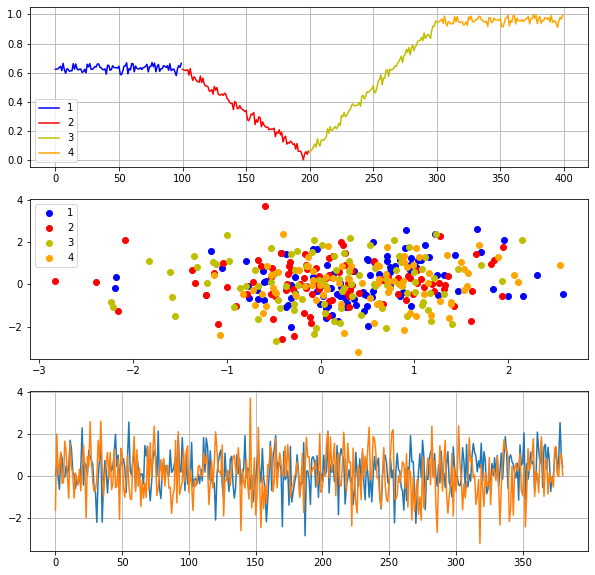

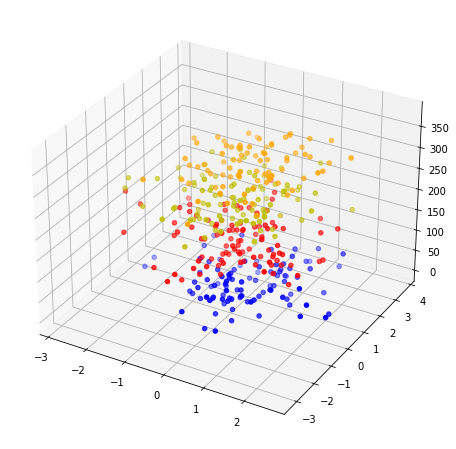

In [177]:
latent_values = vae_cp.get_latent_values(scaled_data)
plot_latent_variables(latent_values, scaled_data)

#### Train the model
The paper states that it trained for 300 epochs, however I found 600 more appropriate. Of course this depends on the learning rate, but this setup seems to work fine for the used data!

In [190]:
epochs = 600
smoothing = input_dim
gamma = 0.25
margin = 64

vae_cp.train(X=scaled_data, epochs=epochs, smoothing=smoothing, gamma=gamma, margin=margin)

Epoch: 10, Loss: {'loss': 64.405655, 'reconstruction_loss': 5.3464174, 'kl_loss': 0.53631556, 'elbo_loss': 5.4804964, 'triplet_loss': 58.92516}, time elapse for epoch: 0.04798698425292969
Epoch: 20, Loss: {'loss': 66.44318, 'reconstruction_loss': 4.3996997, 'kl_loss': 1.6916559, 'elbo_loss': 4.8226132, 'triplet_loss': 61.620567}, time elapse for epoch: 0.045000314712524414
Epoch: 30, Loss: {'loss': 66.46262, 'reconstruction_loss': 4.7077847, 'kl_loss': 2.0440722, 'elbo_loss': 5.218802, 'triplet_loss': 61.243828}, time elapse for epoch: 0.044003963470458984
Epoch: 40, Loss: {'loss': 66.43218, 'reconstruction_loss': 4.2766275, 'kl_loss': 2.0342107, 'elbo_loss': 4.7851796, 'triplet_loss': 61.647015}, time elapse for epoch: 0.09299945831298828
Epoch: 50, Loss: {'loss': 66.735725, 'reconstruction_loss': 4.104945, 'kl_loss': 2.129772, 'elbo_loss': 4.6373878, 'triplet_loss': 62.098354}, time elapse for epoch: 0.05610537528991699
Epoch: 60, Loss: {'loss': 66.304016, 'reconstruction_loss': 3.72

#### Plot the latent values post training

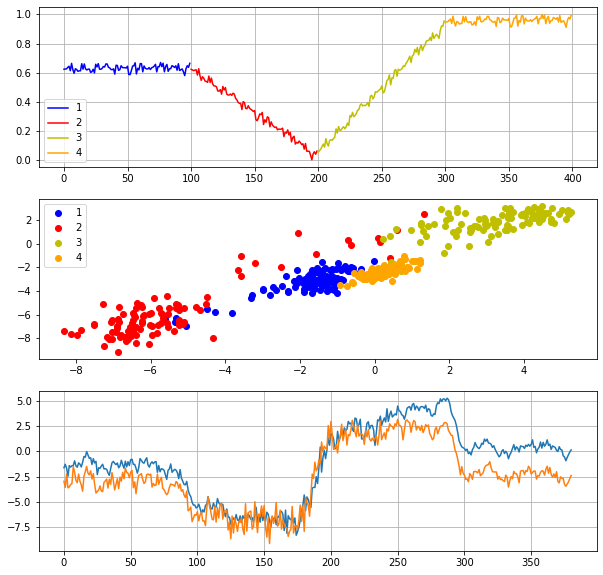

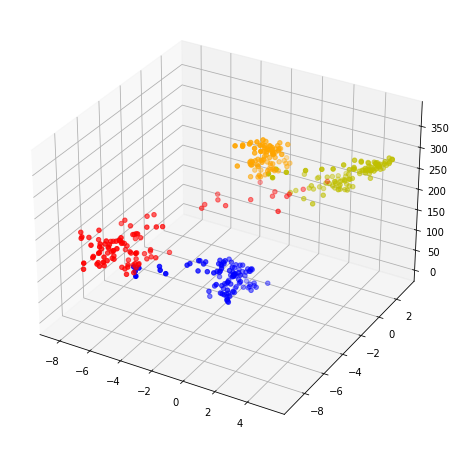

In [191]:
latent_values = vae_cp.get_latent_values(scaled_data)
plot_latent_variables(latent_values, scaled_data)

## Final remarks

The above produced plots should be compared to Figure 1 and Figure 2 from the VAE-CP paper. These can be seen below.  

**Figure 1**  
<img src="image/vae-cp-fig1.png" alt=“VAE”  width="40%" height="40%">  

**Figure 2**  
<img src="image/vae-cp-fig2.png" alt=“VAE”  width="40%" height="40%">  

The code generated plots much reminds of the ones showed in the paper. This leads me to believe the implementation is close to identical to the one used in the paper.